In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

## Spectral Response

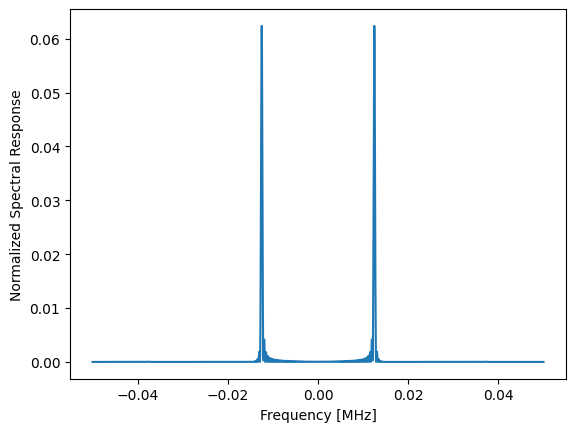

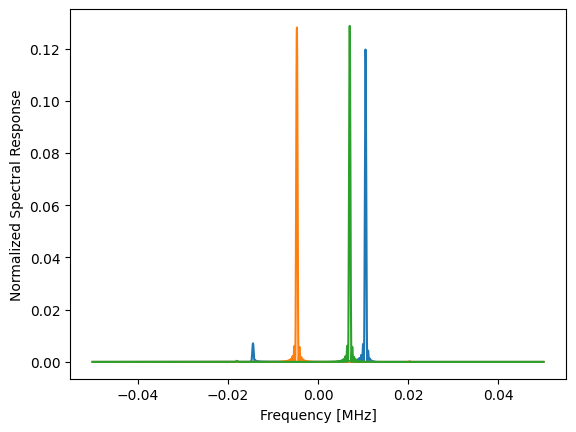

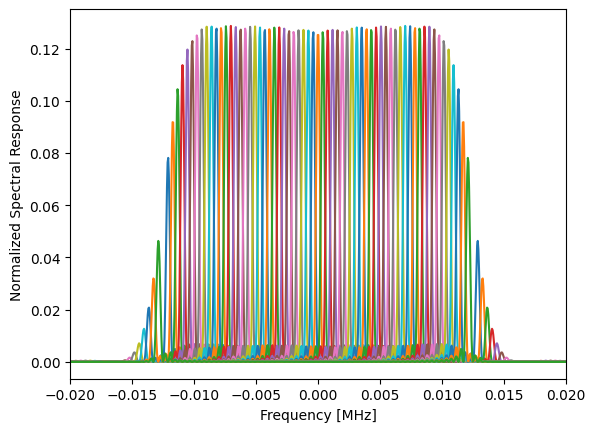

In [2]:
sim = fd.Simulator(None, None)

plt.figure()
plt.plot(sim.offset, sim.spec[:, 0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, -5])
plt.plot(sim.offset, sim.spec[:, 20])
plt.plot(sim.offset, sim.spec[:, 50])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, 1:])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.xlim(-20/1e3, 20/1e3)
plt.show()

## Zenith Source

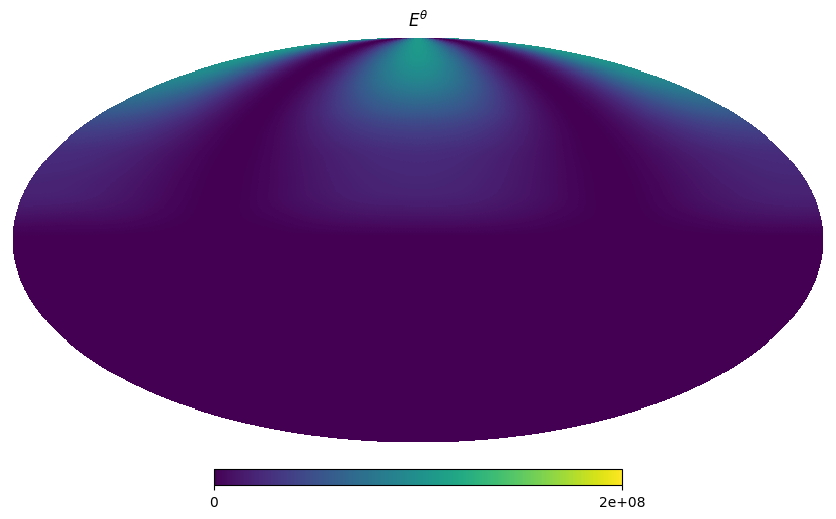

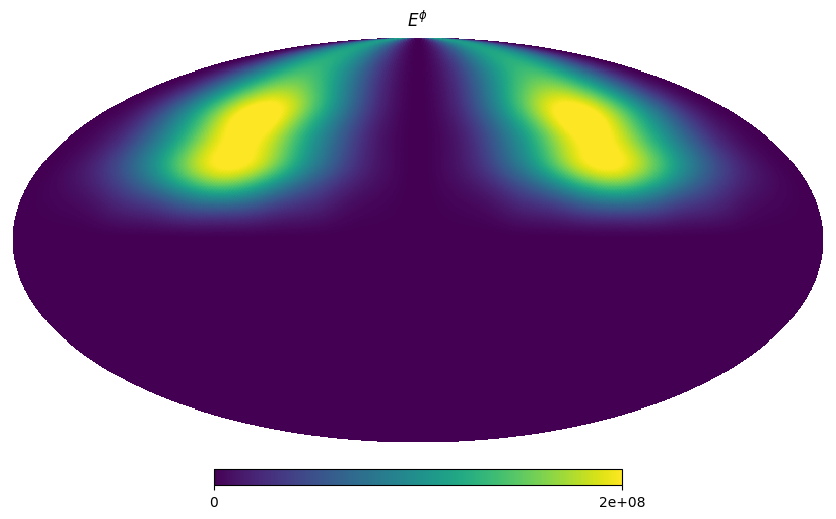

In [3]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=30)

hp.mollview(np.abs(beam.beam_X[0, 0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1, 0])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

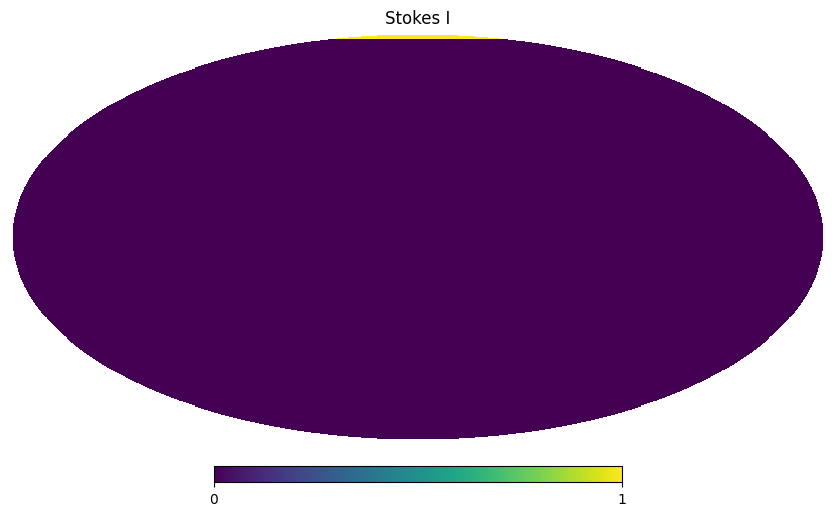

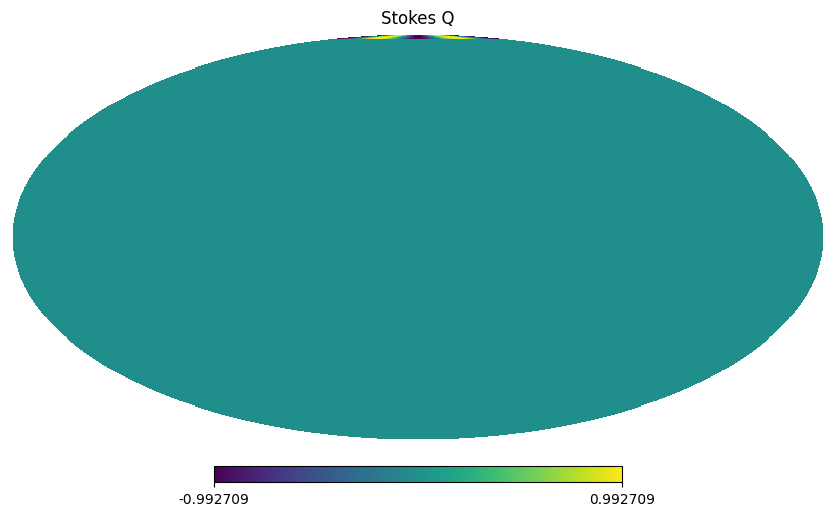

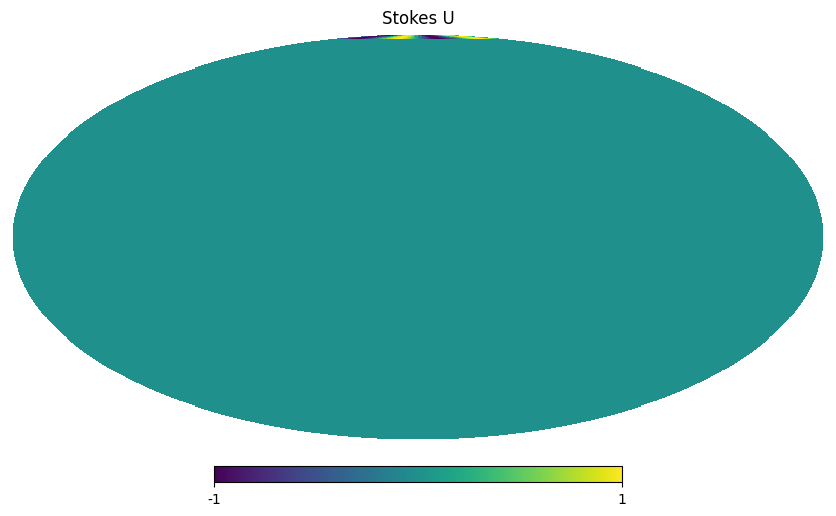

In [4]:
sky = fd.Sky.zeros()
sky.add_point_source()  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[1, 0], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[2, 0], title="Stokes U")
plt.show()

# simulator expects sky at 23 GHz, not 30 MHz
sky.stokes = sky.stokes * (23e3/30)**(-2.5)

/home/christian/Documents/research/lusee/faraday/.venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


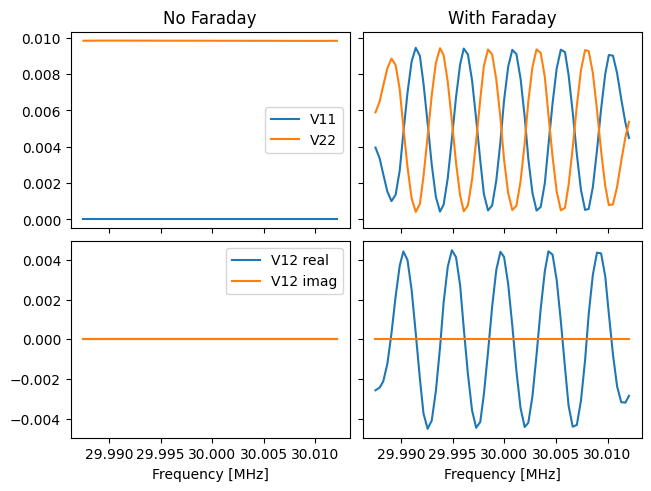

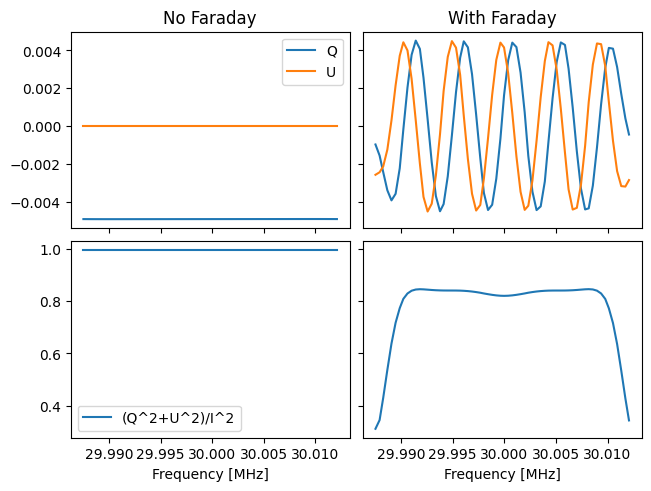

In [5]:
sim = fd.Simulator(beam, sky, full_map=False)
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

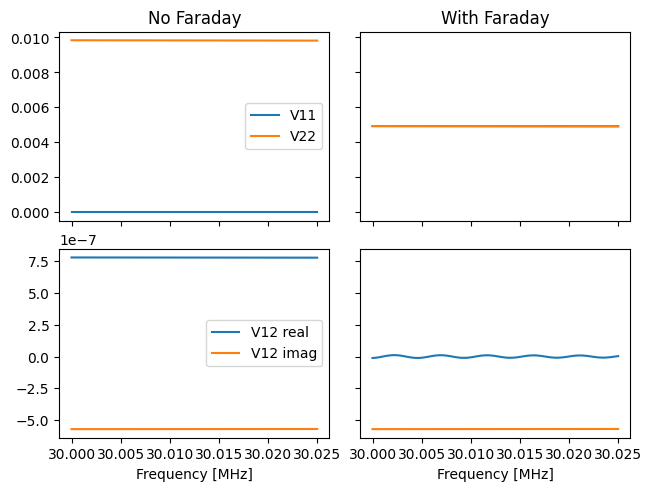

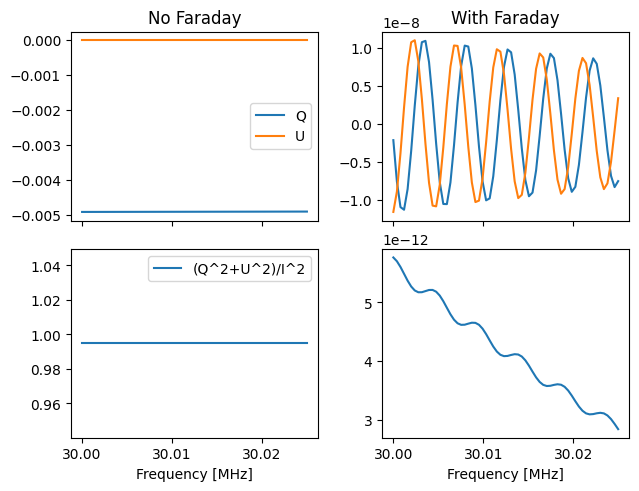

In [6]:
sim.run(channelize="wide")
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, sharey="row")
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot, sharey=False)

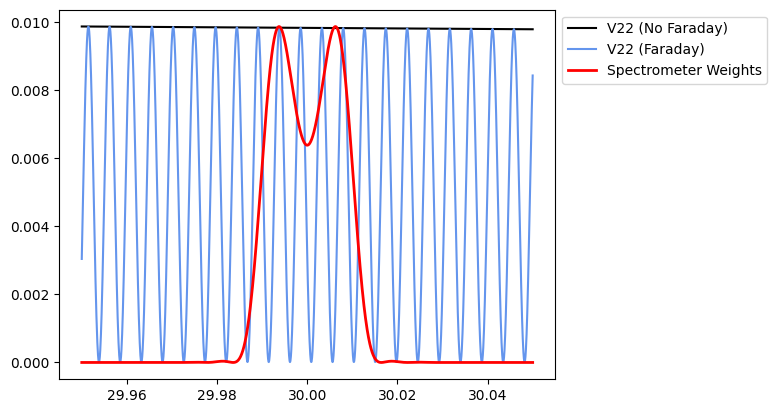

In [7]:
sim_freq = sim.freq[:, None] + sim.offset[None]
sim_freq = sim_freq.flatten()
#ix = sim_freq.argsort()

plt.figure()
plt.plot(sim_freq[:2000], sim._vis[-1, :2000], c="k", label="V22 (No Faraday)")
plt.plot(sim_freq[:2000], sim._vis_rot[-1, :2000], c="cornflowerblue", label="V22 (Faraday)")
plt.plot(sim_freq[:2000], sim.wide_bin * sim._vis_rot[-1].max()/sim.wide_bin.max(), c="red", lw=2, label="Spectrometer Weights")
plt.legend(bbox_to_anchor=[1., 1.])
plt.show()

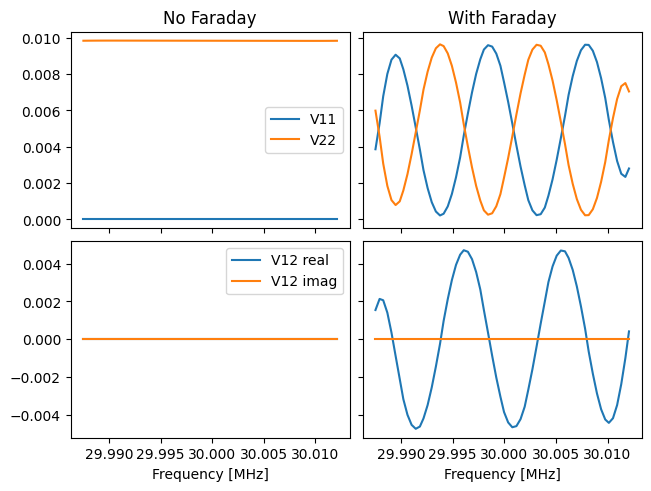

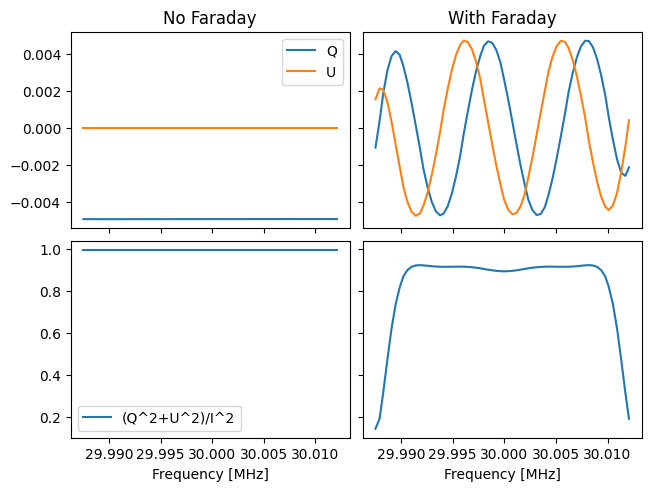

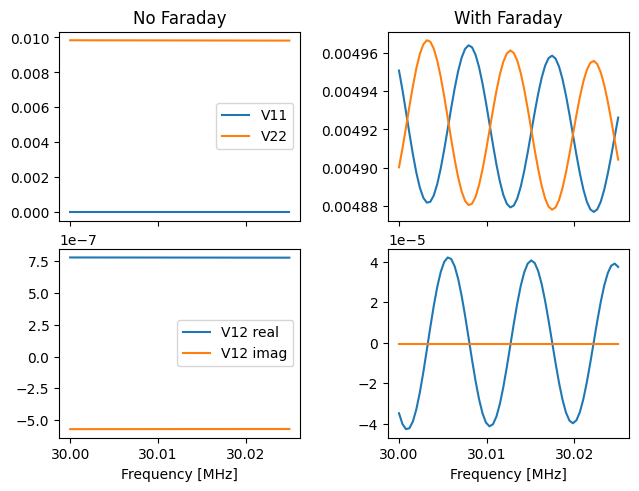

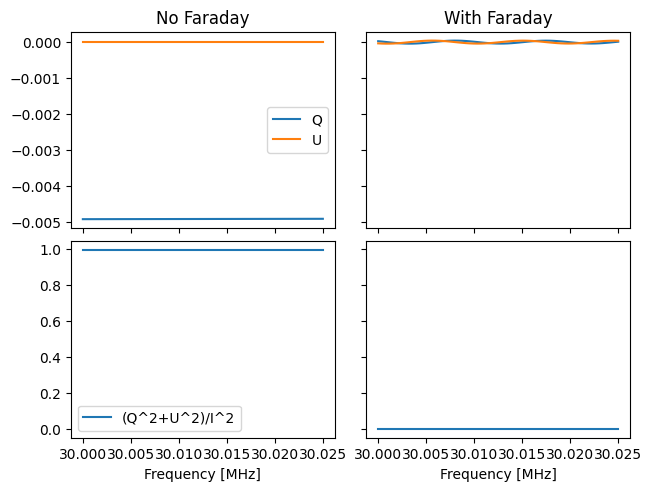

In [8]:
sim.run(channelize="narrow", RM=50)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

sim.run(channelize="wide", RM=50)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, sharey=False)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## 50 MHz

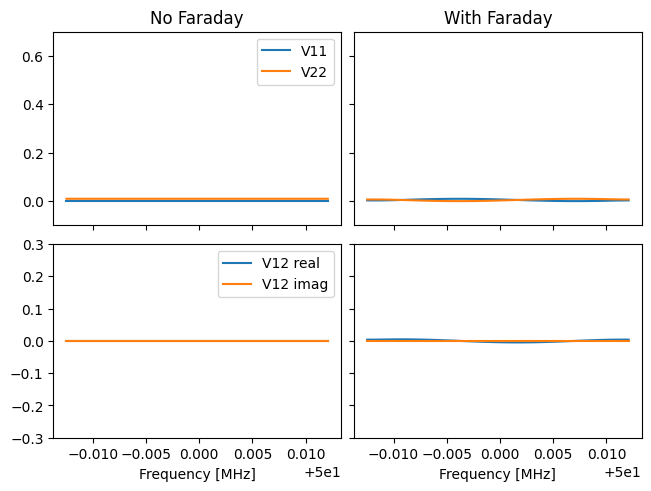

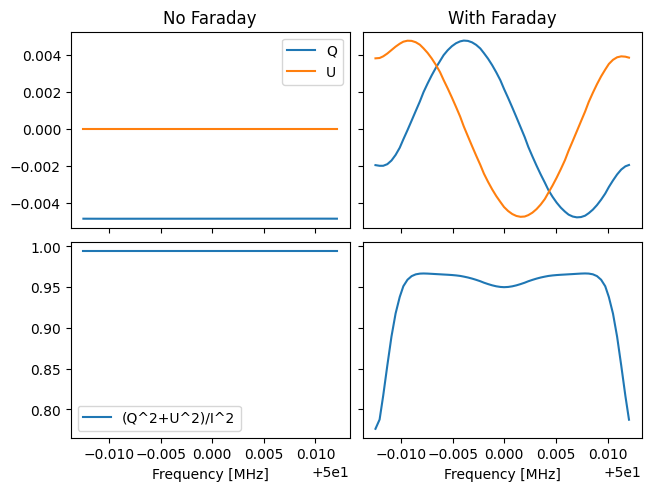

In [9]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=50)
sim = fd.Simulator(beam, sky, center_freq=50)
sim.run(channelize="narrow")
_, axs = fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, return_fig=True)
plt.setp(axs[0], ylim=(-0.1, 0.7))
plt.setp(axs[1], ylim=(-0.3, 0.3))
plt.show()
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

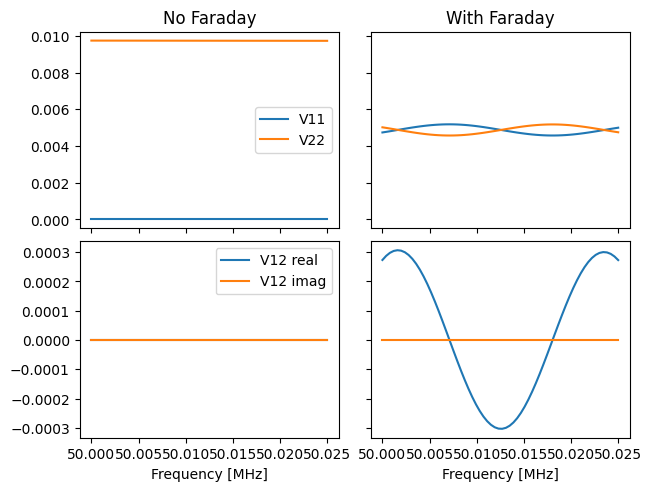

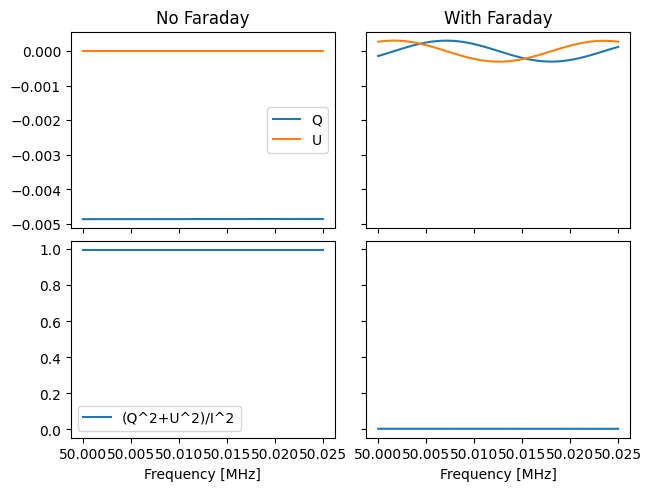

In [11]:
sim = fd.Simulator(beam, sky, center_freq=50)
sim.run(channelize="wide")
_, axs = fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, return_fig=True)
#plt.setp(axs[0], ylim=(-0.1, 0.7))
#plt.setp(axs[1], ylim=(-0.3, 0.3))
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## Off-center source

Instead of moving the source, we rotate the beam.

In [12]:
lat = 60
lon = 20

theta_src = np.deg2rad(90-lat)  # polar angle
phi_src = np.deg2rad(lon)
ct = np.cos(theta_src)
st = np.sin(theta_src)
cp = np.cos(phi_src)
sp = np.sin(phi_src)

x = st * cp
y = st * sp
z = ct

beta = np.arcsin(x)
gamma = np.arctan2(y/np.cos(beta), z/np.cos(beta))

rot = hp.Rotator(rot=(0, beta, gamma), deg=False)

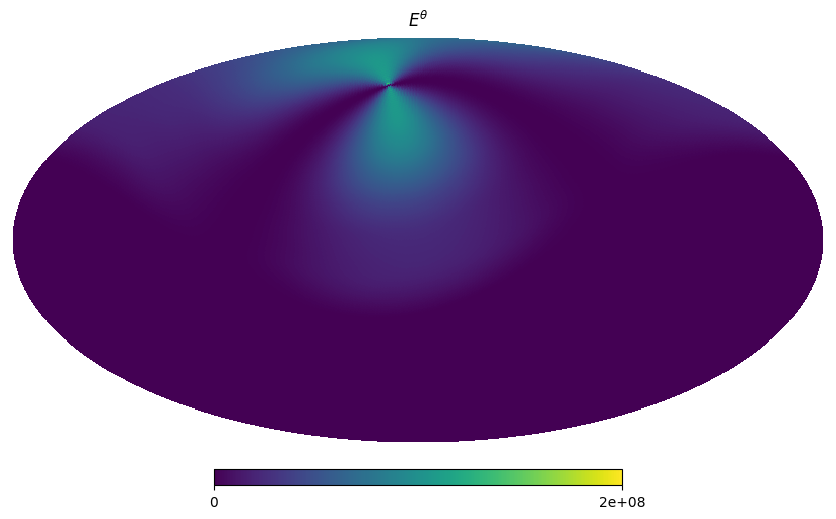

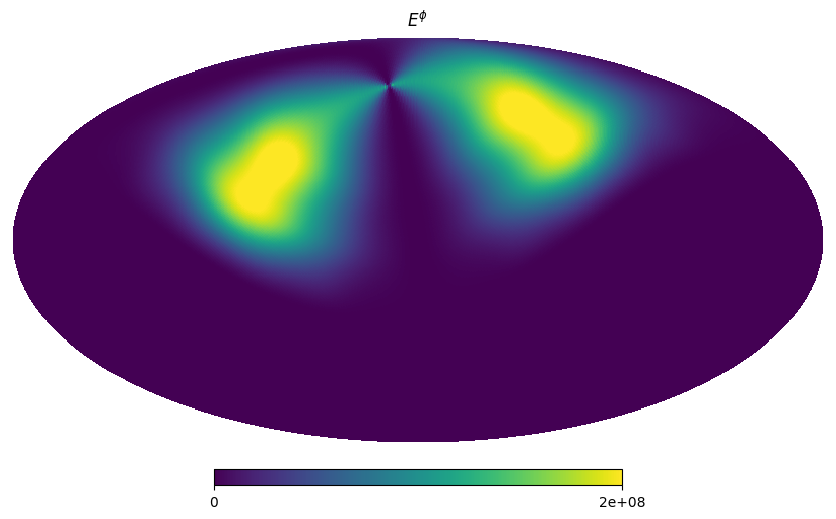

In [14]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits")
beam.rotate(rot)
hp.mollview(np.abs(beam.beam_X[0, 0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1, 0])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

In [17]:
sky = fd.Sky.zeros()
sky.add_point_source()  # 5 deg source at zenith
# simulator expects sky at 23 GHz, not 30 MHz
sky.stokes = sky.stokes * (23e3/30)**(-2.5)

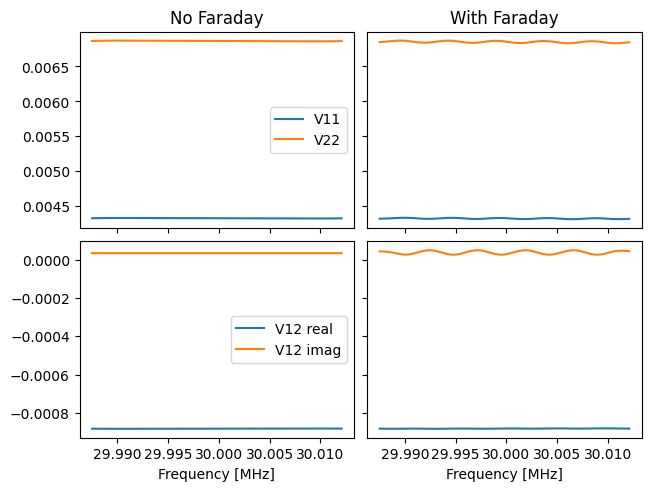

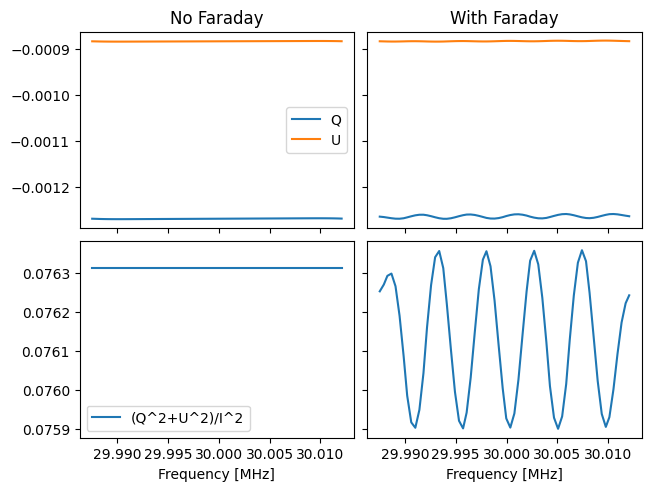

In [18]:
sim = fd.Simulator(beam, sky)
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

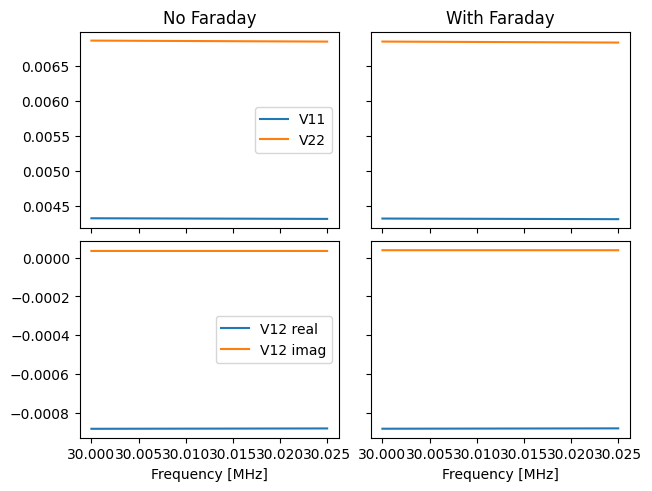

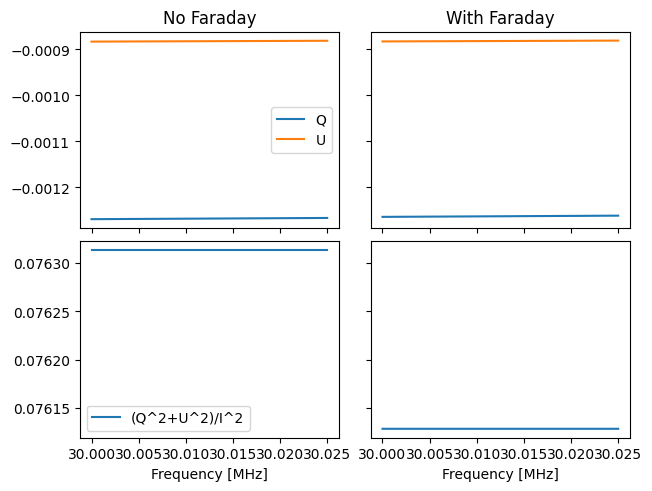

In [19]:
sim = fd.Simulator(beam, sky)
sim.run(channelize="wide")
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)